# KaRMMa Demo

This demo notebook shows the basics of using KaRMMa and some of it's built in utilities.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import karmma
import pickle

## Generating a Mock

We'll first start by generating a mock observation to run KaRMMa on. We'll load up the survey mask, power spectrum, and lognormal shift parameter that we will use for our mock. We then plot the survey mask below.

/Users/pierfied/opt/anaconda3/envs/karmma/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/pierfied/opt/anaconda3/envs/karmma/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/pierfied/opt/anaconda3/envs/karmma/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered col

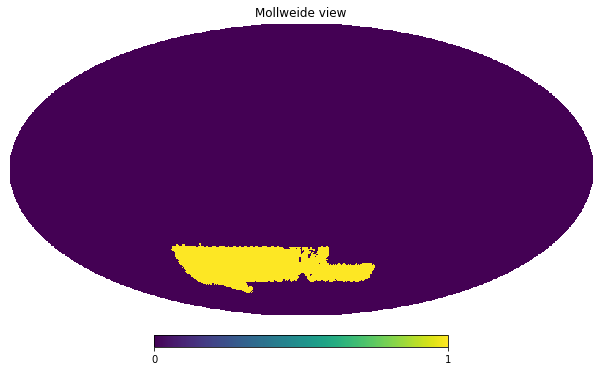

In [2]:
data = pickle.load(open('demo_data.p', 'rb'))

nside = 128
lmax = 256

mask = data['mask']
shift = data['shift']
cl = data['cl']

hp.mollview(mask)

To minimize masking effects, we will perform the reconstruction on the mask with a buffer region. Here, we will use a buffer region of 5 pixels. We can generate the buffered mask using an included KaRMMa utility.

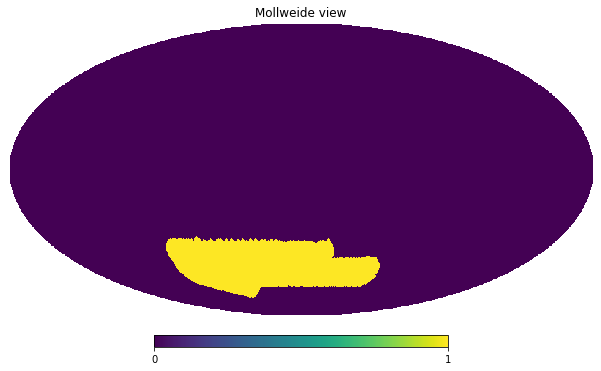

In [3]:
# Add 5 pixels of buffer around the mask.
bmask = karmma.utils.add_buffer(mask, 0)

hp.mollview(bmask)

Now we will generate a simulated weak lensing map. We first compute the pixelized power spectrum, then we transform the power spectrum of the convergence field to the power spectrum of the log-convergence where the field is Gaussian. Next, we generate a lognormal convergence field and use the Kaiser-Squires transform to get the shear field. The fields are visualized below.

_Note_: In this demo we're assuming that the true convergence field only has power up to the well resolved mode, $\ell_\mathrm{max}$. In reality, the true convergence field will have modes out to $\ell = \infty$. For simplicity, we ignore these modes in this demo, however they can be dealt with as detailed in the paper.

/Users/pierfied/opt/anaconda3/envs/karmma/lib/python3.9/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/Users/pierfied/opt/anaconda3/envs/karmma/lib/python3.9/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/Users/pierfied/opt/anaconda3/envs/karmma/lib/python3.9/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


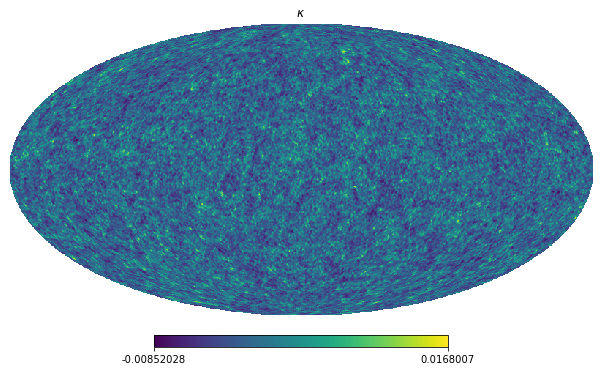

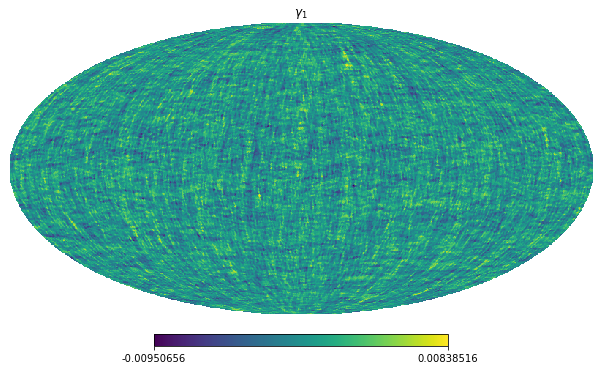

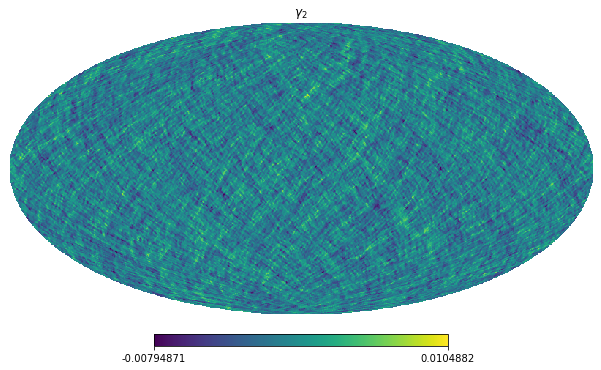

In [4]:
# Apply the pixel window function to the convergence power spectrum.
pw = hp.pixwin(nside, lmax=lmax)
cl_pw = cl * (pw ** 2)

# Compute the power spectrum and mean of the log-convergence field.
gauss_cl = karmma.utils.lognorm_to_gauss_cl(cl_pw, shift, lmax=lmax)
gauss_var = karmma.utils.cl2xi_theta(gauss_cl, 0)
mu = np.log(shift) - 0.5 * gauss_var

# Produce a lognormal mock.
k = np.exp(mu + hp.synfast(gauss_cl, nside)) - shift

# Apply the Kaiser-Squires transformation to get the shear field.
g1, g2 = karmma.utils.conv2shear(k, lmax=lmax)

# Visualize the maps.
hp.mollview(k, title='$\\kappa$')
hp.mollview(g1, title='$\\gamma_1$')
hp.mollview(g2, title='$\\gamma_2$')

Now we'll generate an observed shear map by adding shape noise to the true shear field and applying the survey mask. We'll assume that the shape noise has the same variance as the field itself.

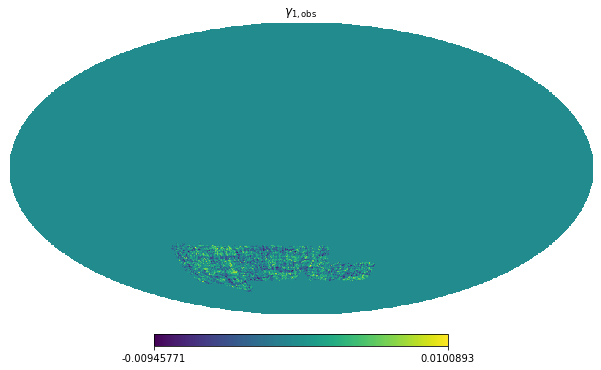

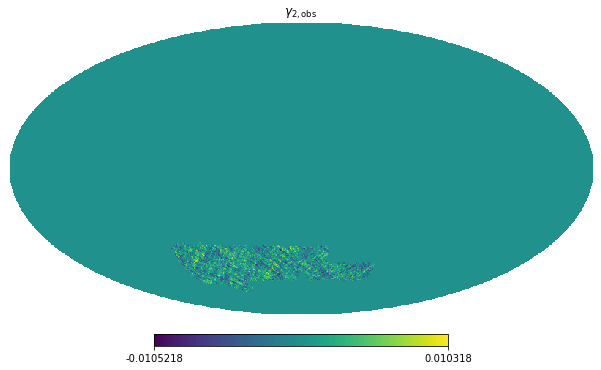

In [5]:
# Assume the shape noise has the same variance as the shear field.
sigma_sn = g1.std()

# Add the shape noise.
g1_obs = (g1 + np.random.standard_normal(len(g1)) * sigma_sn) * mask
g2_obs = (g2 + np.random.standard_normal(len(g2)) * sigma_sn) * mask

# Visualize the maps.
hp.mollview(g1_obs, title='$\\gamma_{1,\mathrm{obs}}$')
hp.mollview(g2_obs, title='$\\gamma_{2,\mathrm{obs}}$')

## Preparing KaRMMa Inputs

We now turn to generating some of the required inputs for KaRMMa. To do this, we will use several of the utilities provided with KaRMMa. Specifically, we will need to generate the prior covariance matrix as well as the matrices for performing the Kaiser-Squires transformation.

We'll start by creating the lognormal prior covariance matrix for all pixels in the buffered mask. We then diagonalize the prior covariance matrix using SVD. Plotted below are the singular values of the covariance matrix (normalized by the largest singular value).

In [ ]:
cov = karmma.utils.cl2cov_mat(cl_pw, nside, mask=bmask, lmax=lmax, log=True, shift=shift)

u, s, _ = np.linalg.svd(cov)

plt.semilogy(s/s[0])
plt.xlabel('Index')
plt.ylabel('Normalized Singular Values')
plt.show()

Computing angular separations:   0%|          | 0/13053 [00:00<?, ?it/s]

We see that the covariance matrix has a large condition number with singular values that span many orders of magnitude. Inverting this matrix as is to get the precision matrix is not numerically stable and will result in poor sampling. Note that the singular values exhibit a several order of magnitude drop at about index 5000. This is expected as we have imposed an $\ell$ cut on the convergence field. Modes beyond this index do not contribute meaningfully to the statistics of the map. Therefore, we can exclude these modes from our model and improve numerical stability. We'll truncate modes such that the condition number is less than $10^{3}$.

In [ ]:
rcond = 1e-3
cut_inds = s / s[0] > 1e-3

u = u[:, cut_inds]
s = s[cut_inds]

## Running KaRMMa